
# 0. Data Loading and Preprocessing


## 0.1. Load Dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os

# Step 1: Load Dataset
csv_path = "hotel_bookings.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at: {csv_path}")

df = pd.read_csv(csv_path)
df.head()


FileNotFoundError: CSV file not found at: hotel_bookings.csv

## 0.2. BEFORE CLEANING - Missing Values Overview

Missing values PER COLUMN (before cleaning):
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent       

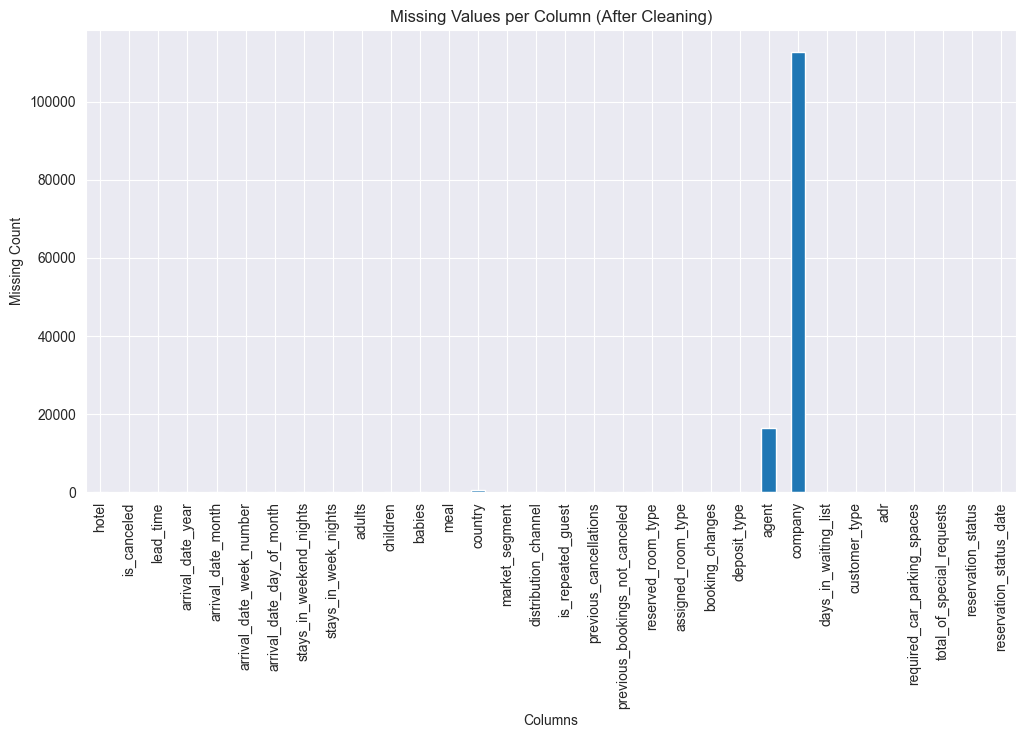

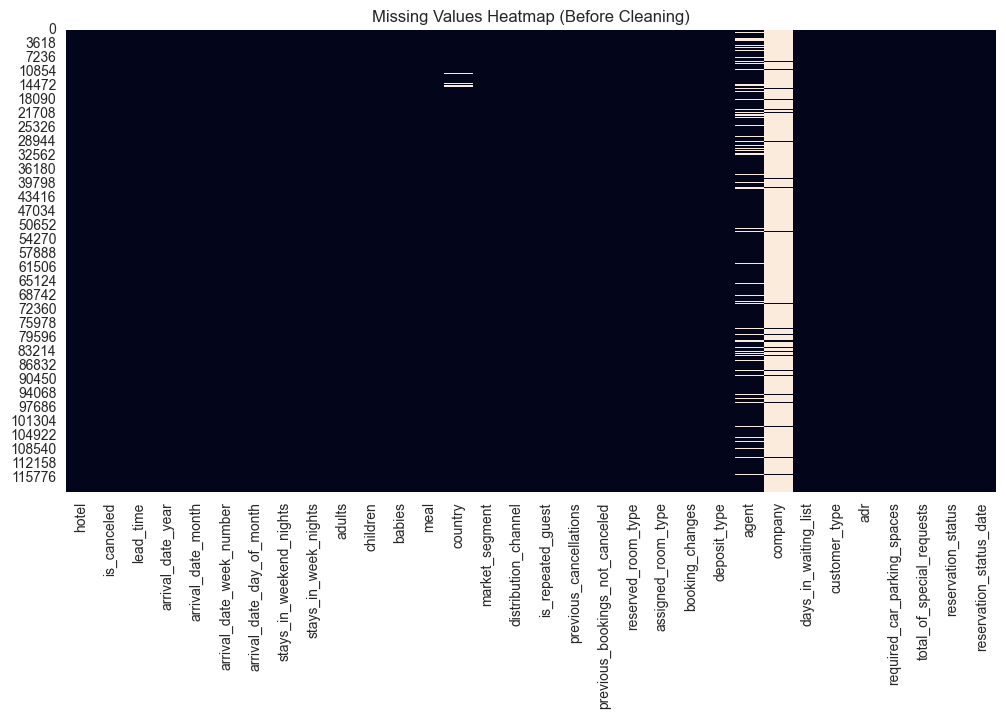

In [ ]:

print("Missing values PER COLUMN (before cleaning):")
print(df.isna().sum())

print("\nTotal missing before cleaning:", df.isna().sum().sum())

plt.figure(figsize=(12,6))
df.isna().sum().plot(kind='bar')
plt.title("Missing Values per Column (After Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (Before Cleaning)")
plt.show()

## 0.3. Handle Missing Values

In [ ]:

df["children"] = df["children"].fillna(0)
df["country"] = df["country"].fillna("Unknown")
df["agent"] = df["agent"].fillna(0)
df["company"] = df["company"].fillna(0)

print("\nMissing values handled.")


Missing values handled.


## 0.4. AFTER CLEANING - Missing Values Check


Missing values PER COLUMN (after cleaning):
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type      

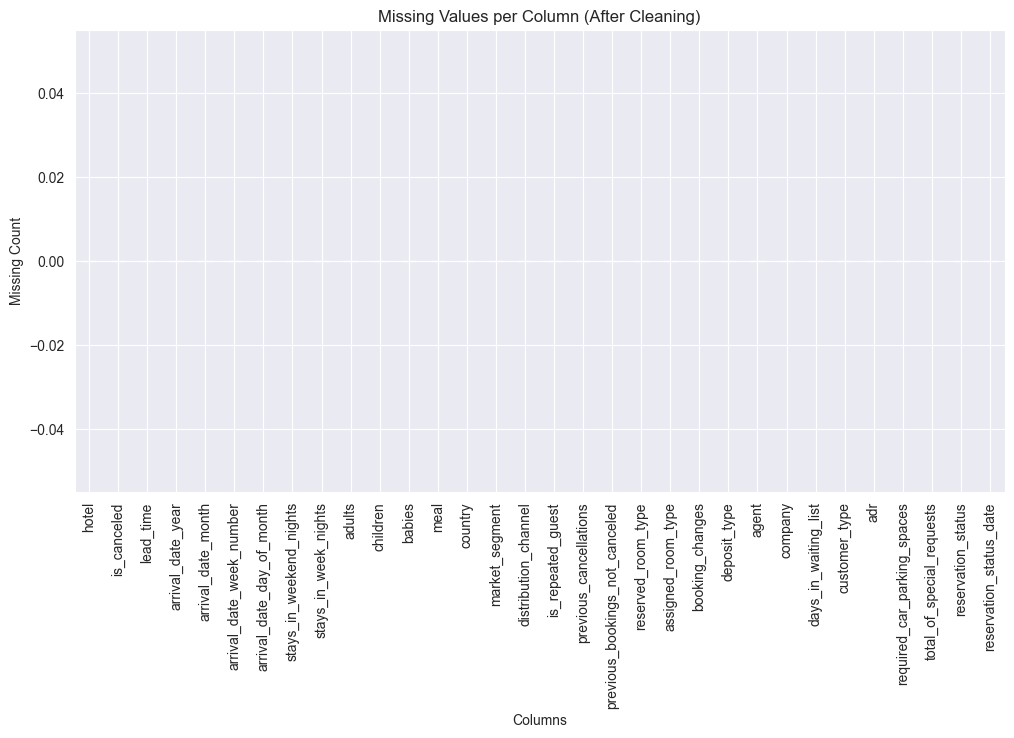

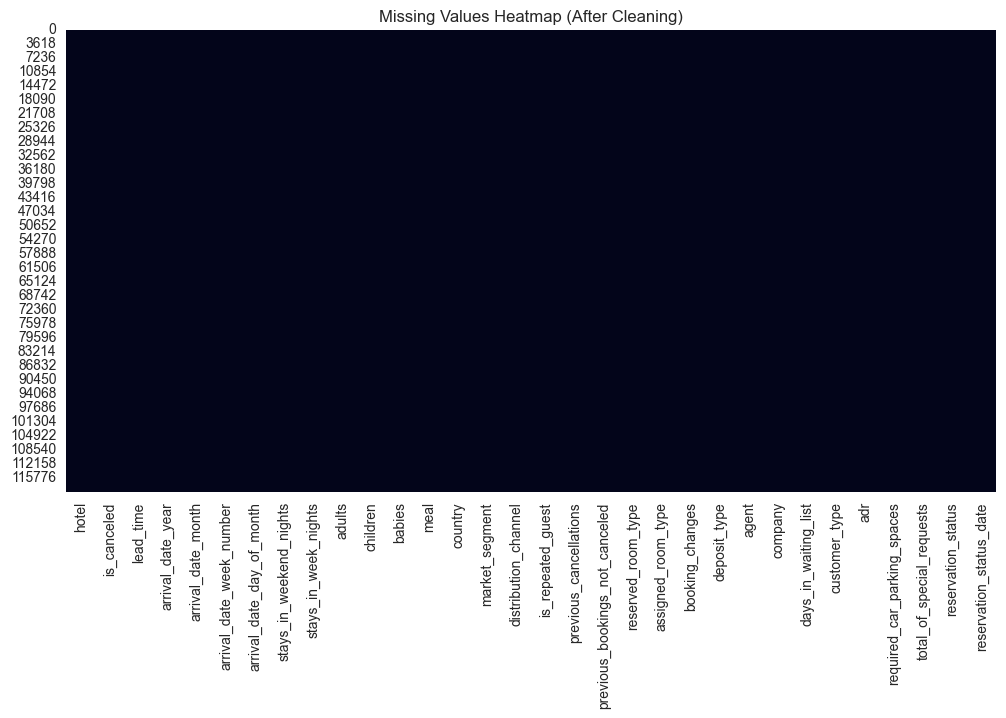

In [ ]:

print("\nMissing values PER COLUMN (after cleaning):")
print(df.isna().sum())

print("\nTotal missing after cleaning:", df.isna().sum().sum())

plt.figure(figsize=(12,6))
df.isna().sum().plot(kind='bar')
plt.title("Missing Values per Column (After Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.show()


plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (After Cleaning)")
plt.show()

## 0.4. Remove Invalid Rows (Bookings with no guests)

In [ ]:

invalid_rows = (df["adults"] == 0) & (df["children"] == 0) & (df["babies"] == 0)
print("Number of invalid rows with no guests:", invalid_rows.sum())

df = df[~invalid_rows]
print("Shape after removing invalid rows:", df.shape)

Number of invalid rows with no guests: 180
Shape after removing invalid rows: (119210, 32)


## 0.6. Create Derived Variables

In [ ]:

df["total_guests"] = df["adults"] + df["children"] + df["babies"]
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_date_month"].astype(str) + "-" +
    df["arrival_date_day_of_month"].astype(str),
    errors="coerce"
)

df = df.dropna(subset=["arrival_date"])

df["arrival_month"] = df["arrival_date"].dt.month
df["arrival_weekday"] = df["arrival_date"].dt.day_name()

print("\nDerived variables created.")
print(df[["total_guests", "total_nights", "arrival_date"]].head())


Derived variables created.
   total_guests  total_nights arrival_date
0           2.0             0   2015-07-01
1           2.0             0   2015-07-01
2           1.0             1   2015-07-01
3           1.0             1   2015-07-01
4           2.0             2   2015-07-01


## 0.7. Basic Validation

In [ ]:
if df.empty:
    raise DataValidationError("Dataset became empty after cleaning.")

if not df["is_canceled"].isin([0, 1]).all():
    raise DataValidationError("Invalid values found in is_canceled column.")

if (df["total_guests"] <= 0).any():
    raise DataValidationError("Found rows with zero or negative guests.")

if (df["total_nights"] < 0).any():
    raise DataValidationError("Found negative night counts.")

if not pd.api.types.is_datetime64_any_dtype(df["arrival_date"]):
    raise DataValidationError("arrival_date is not datetime type.")

print("\nValidation passed successfully.")


Validation passed successfully.



# 1. Exploratory Data Analysis


## 1.1. Descriptive Statistics for key variables

In [ ]:
print("Average ADR:", df['adr'].mean()) #Find average ADR
print("Total bookings:", len(df)) #Total number of bookings
print("Range of lead_time:", df['lead_time'].max() - df['lead_time'].min()) #Range of Lead Time

Average ADR: 101.96909177082459
Total bookings: 119210
Range of lead_time: 737


In [ ]:
key_vars = ["lead_time", "adr", "total_guests", "total_nights"]
df[key_vars].describe() #Basic Summary Statistics

,lead_time,adr,total_guests,total_nights
count,119210.000000,119210.000000,119210.000000,119210.000000
mean,104.109227,101.969092,1.971210,3.426248
std,106.875450,50.434007,0.718876,2.540692
min,0.000000,-6.380000,1.000000,0.000000
25%,18.000000,69.500000,2.000000,2.000000
50%,69.000000,94.950000,2.000000,3.000000
75%,161.000000,126.000000,2.000000,4.000000
max,737.000000,5400.000000,55.000000,69.000000


## 1.2. Cancelled vs. Non-Cancelled Bookings

In [ ]:
df["is_canceled"].value_counts(normalize=True) * 100 #Counts how many times 0 or 1 appears and finds the percentage

is_canceled
0    62.923412
1    37.076588
Name: proportion, dtype: float64

Comparing cancelled vs. non-cancelled bookings. 62.9% of bookings were not cancelled, whereas 37.1% were cancelled.

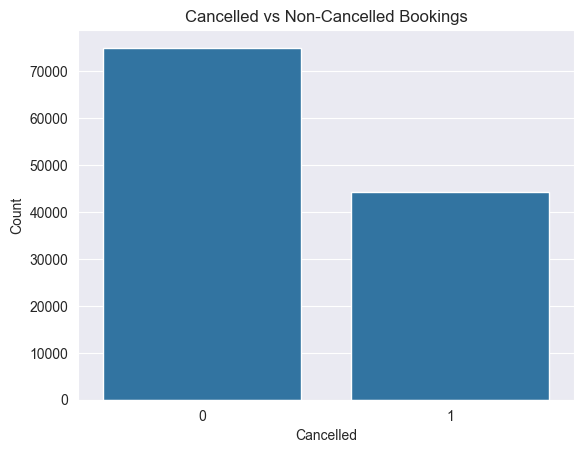

In [ ]:
sns.countplot(x="is_canceled", data=df) #Plots the count of each category
plt.xlabel("Cancelled")
plt.ylabel("Count")
plt.title("Cancelled vs Non-Cancelled Bookings")
plt.show()


Displaying a count of cancelled vs. non-cancelled bookings ~75,000 bookings were not cancelled and ~45,000 were.

In [ ]:
grouped_means = df.groupby("is_canceled")[key_vars].mean() #mean of lead time, adr, total guests, and total nights for cancelled bookings
print(grouped_means)

              lead_time         adr  total_guests  total_nights
is_canceled                                                    
0             80.082028  100.169212      1.946475      3.390063
1            144.886264  105.023703      2.013190      3.487658


Canceled bookings tend to be made much further in advance than non-canceled bookings, with an average lead time of about 145 days compared to 80 days. Canceled reservations also have slightly higher average daily rates, marginally more guests, and slightly longer stays. This suggests that bookings made far ahead of time are more uncertain and therefore more likely to be canceled, while differences in price and group size play a smaller role.

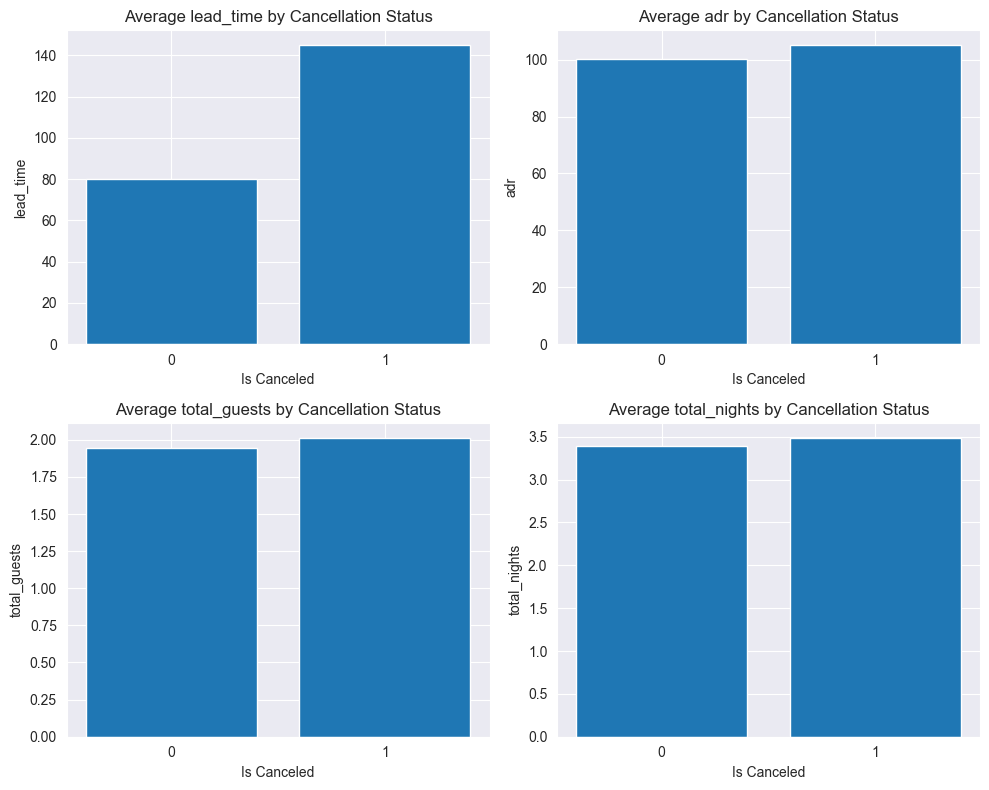

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) #create 4 subplots
axes = axes.flatten() #turns the 2x2 grid into a 1D list to loop over it easily

for i, var in enumerate(key_vars):
    axes[i].bar(grouped_means.index.astype(str), grouped_means[var]) #draw one bar chart for each variable in key_vars-- lead time, adr, total guests, total nights
    axes[i].set_title(f"Average {var} by Cancellation Status")
    axes[i].set_xlabel("Is Canceled")
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

This is a visualization of the above findings.

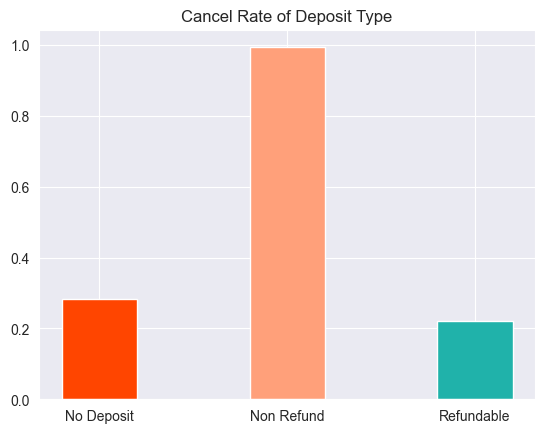

In [ ]:
deposit_cancel=(df[df['is_canceled']==1]['deposit_type'].value_counts()/df['deposit_type'].value_counts()) #finding percentage of cancelled bookings by deposit type
x=range(len(deposit_cancel.index))
y=deposit_cancel.values
plt.bar(x,y,color=['orangered','lightsalmon','lightseagreen'],width=0.4)
plt.xticks(x,deposit_cancel.index)
plt.title('Cancel Rate of Deposit Type');

Bookings with refundable or no-deposit policies have significantly higher cancellation rates, while non-refundable bookings are much less likely to be canceled. This suggests that stricter deposit policies discourage cancellations.

In [ ]:
book_per_month = df.groupby("arrival_date_month").size() #Find the number of bookings per month
cancel_per_month = df.groupby("arrival_date_month")["is_canceled"].sum() #Find the number of cancelled bookings per month

#Create Dataframe
cancel_data = pd.DataFrame({
    "Month": list(book_per_month.index),
    "Bookings": list(book_per_month.values),
    "cancellations": list(cancel_per_month.values)})

full_cancel_data["cancel_percent"] = full_cancel_data["cancellations"] / full_cancel_data["Bookings"] * 100 #Column with the percent of cancellations per month

# Order by month
ordered_months = ["January", "February", "March", "April", "May", "June",
                  "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# Display the table sorted by month
display(full_cancel_data.sort_values("Month"))

,Month,Bookings,cancellations,cancel_percent
4,January,5921,1806,30.501604
3,February,8052,2693,33.445107
7,March,9768,3148,32.227682
0,April,11078,4518,40.783535
8,May,11780,4677,39.702886
6,June,10929,4534,41.485955
5,July,12644,4737,37.464410
1,August,13861,5237,37.782267
11,September,10500,4115,39.190476
10,October,11147,4246,38.090966


Cancellation rates show clear seasonality across the year. They are lowest in the winter months (January–March), averaging around 30–33%, and riseduring the spring and summer period. The highest cancellation rates occur between April and June, peaking in June at over 41%, before gradually declining toward the end of the year. This suggests that bookings made for peak travel seasons are more uncertain and therefore more likely to be canceled.

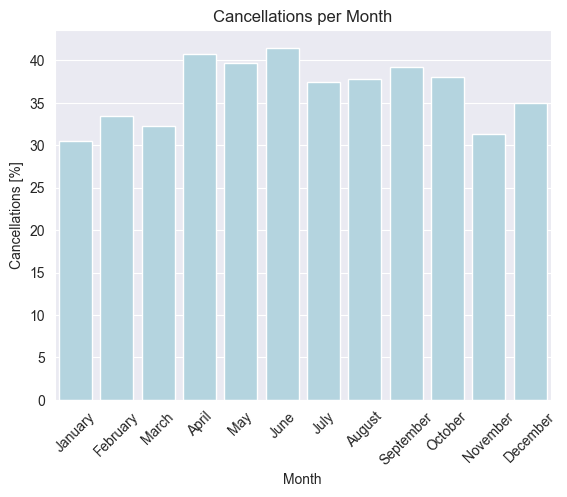

In [ ]:
sns.barplot(x="Month", y="cancel_percent", data=full_cancel_data, color='lightblue')
plt.title("Cancellations per Month")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("Cancellations [%]")
plt.show()

Visualization of above dataframe.

## 1.3. Visualizations

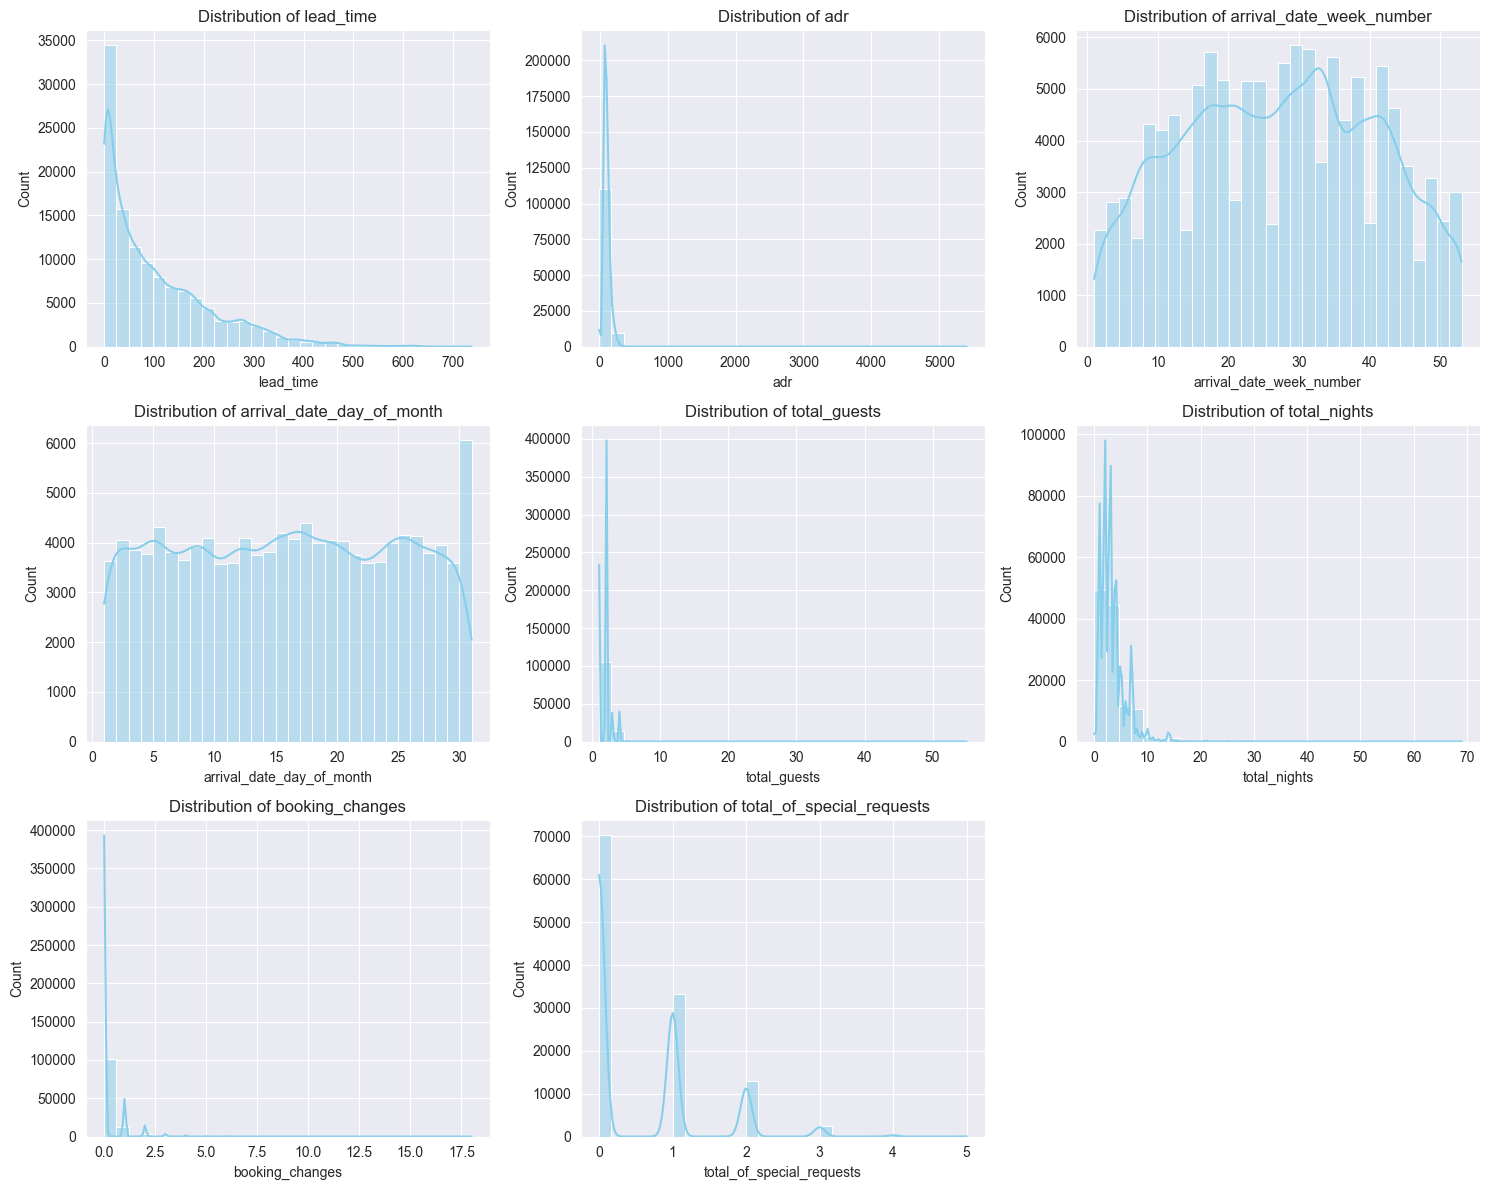

In [ ]:
numeric_features = ["lead_time", "adr","arrival_date_week_number", "arrival_date_day_of_month", "total_guests", "total_nights","booking_changes", "total_of_special_requests"] #List of numeric columns

#Subplot layout
n_num = len(numeric_features)
n_cols = 3
n_rows = math.ceil(n_num / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue') #One histogram per variable in numeric_features
    axes[i].set_title(f"Distribution of {col}")

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

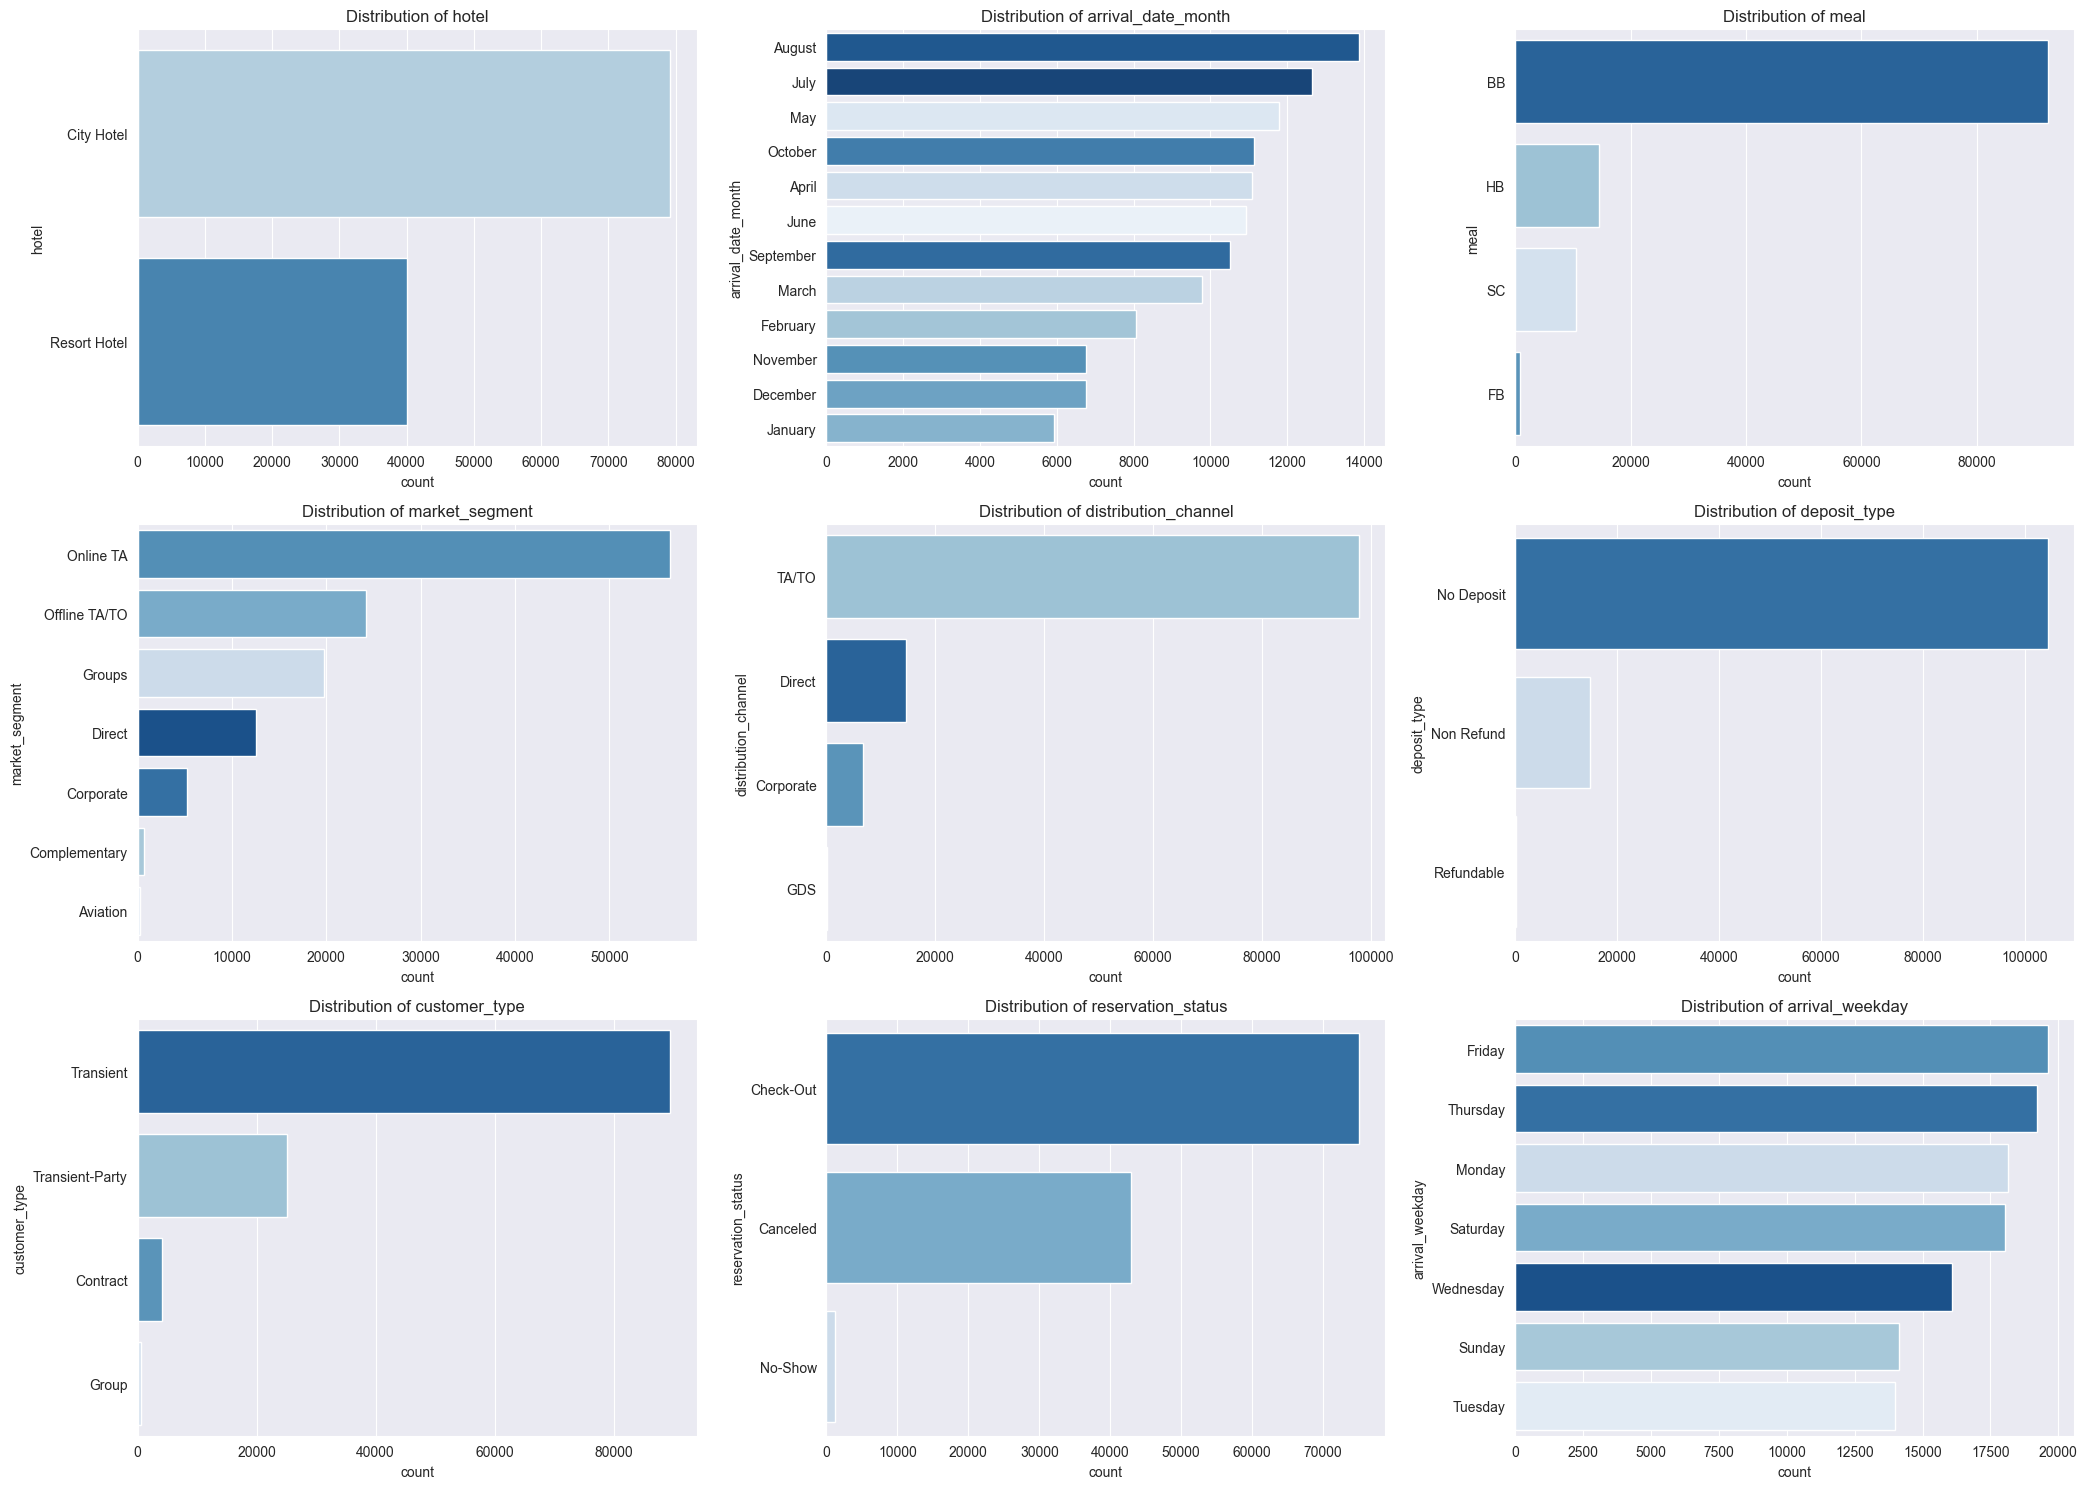

In [ ]:
exclude_cols = ['reservation_status_date', 'country',"assigned_room_type","reserved_room_type"] #Categorical values toe exclude
exclude_values = ['Undefined', 'None'] #Uninformative Data

categorical_features = [
    col for col in df.select_dtypes(include=['object', 'category']).columns
    if col not in exclude_cols #Keep columns not included in exclude_cols
]

#Subplot layout
n_cat = len(categorical_features)
n_cols = 3
n_rows = math.ceil(n_cat / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    filtered_df = df[~df[col].isin(exclude_values)] #Keep only valid category variables

    sns.countplot(
        y=filtered_df[col],
        hue=filtered_df[col],
        order=filtered_df[col].value_counts().index,
        ax=axes[i],
        palette="Blues_r",
        legend=False
    )
    axes[i].set_title(f"Distribution of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j]) #Remove unused subplots

plt.tight_layout()
plt.show()

## 1.4 Correlation Analysis Using NumPy

In [ ]:
corr_vars = ["lead_time", "adr", "total_guests", "total_nights", "is_canceled"]

corr_matrix = np.corrcoef(df[corr_vars].dropna().values.T)
corr_matrix

corr_df = pd.DataFrame(
    corr_matrix,
    index=corr_vars,
    columns=corr_vars
)

corr_df

,lead_time,adr,total_guests,total_nights,is_canceled
lead_time,1.000000,-0.065018,0.070210,0.158294,0.292876
adr,-0.065018,1.000000,0.363711,0.069760,0.046492
total_guests,0.070210,0.363711,1.000000,0.118753,0.044826
total_nights,0.158294,0.069760,0.118753,1.000000,0.018554
is_canceled,0.292876,0.046492,0.044826,0.018554,1.000000


## 1.5. Seasonal Analysis by Month and Hotel Type

In [ ]:
seasonal_adr = df.groupby(["arrival_month", "hotel"])["adr"].mean()
seasonal_adr

arrival_month  hotel       
1              City Hotel       82.754477
               Resort Hotel     49.507033
2              City Hotel       85.327519
               Resort Hotel     55.189716
3              City Hotel       92.973339
               Resort Hotel     57.554652
4              City Hotel      111.397415
               Resort Hotel     77.849496
5              City Hotel      121.764614
               Resort Hotel     78.758134
6              City Hotel      119.186056
               Resort Hotel    110.481032
7              City Hotel      110.945950
               Resort Hotel    155.181299
8              City Hotel      114.857330
               Resort Hotel    186.790574
9              City Hotel      110.120296
               Resort Hotel     93.252030
10             City Hotel      100.119313
               Resort Hotel     62.132572
11             City Hotel       88.372486
               Resort Hotel     48.313643
12             City Hotel       89.209560
      

City Hotels display relatively stable pricing throughout the year, while Resort Hotels experience strong seasonal fluctuations with significantly higher ADRs during the summer months, reflecting leisure-driven demand.

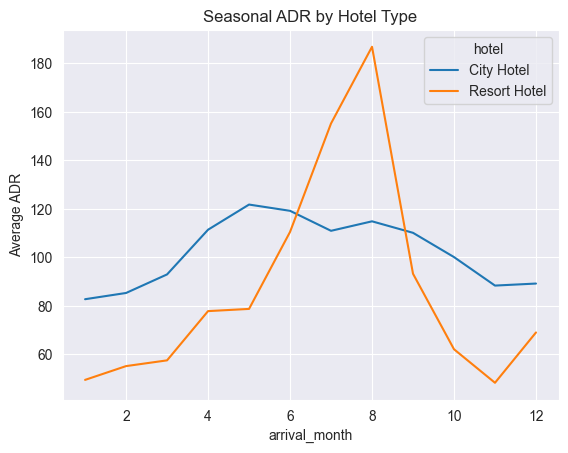

In [ ]:
seasonal_adr.unstack().plot()
plt.ylabel("Average ADR")
plt.title("Seasonal ADR by Hotel Type")
plt.show()

Visualization of above findings.